In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [ ]:
!nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


In [ ]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cpu


### 1/ Prepare Data

In [ ]:
weight = 0.9
bias = 0.3

X = torch.arange(0, 1, 0.02).unsqueeze(dim=1)
y = weight * X + bias

X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3180],
         [0.3360],
         [0.3540],
         [0.3720],
         [0.3900],
         [0.4080],
         [0.4260],
         [0.4440],
         [0.4620]]))

In [ ]:
# Separate train-test set
test_split = int(0.2 * len(X))

# Initialize X_test and y_test as empty lists
X_test = []
y_test = []

# Random split
for i in range(test_split):
  rand_idx = torch.randint(0, len(X), size=[1])
  X_test.append(X[rand_idx])
  y_test.append(y[rand_idx])

# Create a mask to identify the indices of the test set elements in the original tensors
mask = torch.ones(len(X), dtype=torch.bool)
for idx in X_test:
    mask[torch.where(X == idx)[0]] = False

# Use the mask to select the elements that are not in the test set for the training set
X_train = X[mask]
y_train = y[mask]

# Convert lists to tensors after appending
X_test = torch.cat(X_test)
y_test = torch.cat(y_test)

X.shape, y.shape, X_train.shape, y_train.shape, X_test.shape, y_test.shape


(torch.Size([50, 1]),
 torch.Size([50, 1]),
 torch.Size([41, 1]),
 torch.Size([41, 1]),
 torch.Size([10, 1]),
 torch.Size([10, 1]))

In [ ]:
# Visualize
def plot_predictions(train_data=X_train, train_labels=y_train,
                     test_data=X_test, test_labels=y_test,
                     predictions=None):

  plt.figure(figsize=(10, 7))

  # Plot training data in blue
  plt.scatter(train_data, train_labels, c="b", s=4, alpha=0.7, label="Training data")

  # Plot test data in green
  plt.scatter(test_data, test_labels, c="black", s=4, alpha=0.7, label="Testing data")

  # Plot the predictions if it not none
  if predictions is not None:
    plt.scatter(test_data, predictions, c="r", s=4, alpha=0.7, label="Predictions")

  plt.legend(fontsize=14)
  plt.xlabel("X", fontsize=14)
  plt.ylabel("y", fontsize=14)
  plt.show()


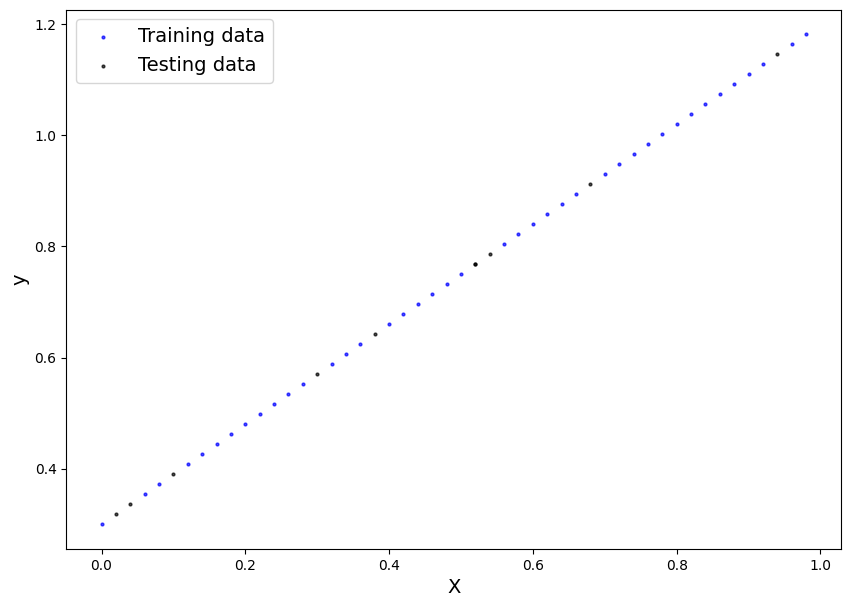

In [ ]:
plot_predictions(X_train, y_train, X_test, y_test)

### 2/ Build Model

In [ ]:
class LinearRegressionModel(nn.Module):
  def __init__(self, in_features, out_features):
    super().__init__()
    self.weights = nn.Parameter(torch.randn(in_features, dtype=torch.float),
                                requires_grad=True)
    self.bias = nn.Parameter(torch.randn(out_features, dtype=torch.float),
                             requires_grad=True)

  def forward(self, X: torch.Tensor) -> torch.Tensor:
    return self.weights * X + self.bias

In [69]:
torch.manual_seed(torch.randint(11, 999, size=[1]))
# Create model
model = LinearRegressionModel(X_train.shape[1], y_train.shape[1])

# Before training params
print('Params before training:', model.state_dict())

# Check device
print('Original Device:', next(model.parameters()).device)

# Put model to gpu
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

# Check again
print('Device after setup:', next(model.parameters()).device)


Params before training: OrderedDict([('weights', tensor([0.7867])), ('bias', tensor([-1.2713]))])
Original Device: cpu
Device after setup: cpu


### 3/ Training Phase

In [70]:
# Create the loss function (Choose L2 Loss)
loss_func = nn.MSELoss()

# Create the optimizer (Choose AdamOptimizer)
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.01)

In [ ]:
# PyTorch training loop steps
# 1. Forward pass - The model goes through all of the training data once, performing its forward() function calculations (model(x_train)).

# 2. Calculate the loss - The model's outputs (predictions) are compared to the ground truth and evaluated to see how wrong they are (loss = loss_fn(y_pred, y_train).

# 3. Zero gradients - The optimizers gradients are set to zero (they are accumulated by default) so they can be recalculated for the specific training step (optimizer.zero_grad()).

# 4. Perform backpropagation on the loss - Computes the gradient of the loss with respect for every model parameter to be updated (each parameter with requires_grad=True). This is known as backpropagation, hence "backwards" (loss.backward()).

# 5. Step the optimizer (gradient descent) - Update the parameters with requires_grad=True with respect to the loss gradients in order to improve them (optimizer.step()).

In [71]:
torch.manual_seed(10)

# Set the number of epochs
epochs = 1000

# Put data on the available device
# Without this, error will happen (not all model/data on device)
X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

%time
for epoch in range(epochs):
    ### Training
    model.train() # train mode is on by default after construction

    # 1. Forward pass
    y_pred = model(X_train)

    # 2. Calculate loss
    loss = loss_func(y_pred, y_train)

    # 3. Zero grad optimizer
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Step the optimizer
    optimizer.step()

    ### Testing
    model.eval() # put the model in evaluation mode for testing (inference)
    # 1. Forward pass
    with torch.inference_mode():
        test_pred = model(X_test)

        # 2. Calculate the loss
        test_loss = loss_func(test_pred, y_test)

    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Train loss: {loss} | Test loss: {test_loss}")

%time

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.91 µs
Epoch: 0 | Train loss: 2.6557111740112305 | Test loss: 2.570697546005249
Epoch: 10 | Train loss: 2.1864306926727295 | Test loss: 2.1412220001220703
Epoch: 20 | Train loss: 1.7716330289840698 | Test loss: 1.759935736656189
Epoch: 30 | Train loss: 1.414542555809021 | Test loss: 1.4296962022781372
Epoch: 40 | Train loss: 1.1144605875015259 | Test loss: 1.1499217748641968
Epoch: 50 | Train loss: 0.8676972985267639 | Test loss: 0.9174448847770691
Epoch: 60 | Train loss: 0.6687917709350586 | Test loss: 0.7275828719139099
Epoch: 70 | Train loss: 0.5115047693252563 | Test loss: 0.574987530708313
Epoch: 80 | Train loss: 0.38946476578712463 | Test loss: 0.45419248938560486
Epoch: 90 | Train loss: 0.29656171798706055 | Test loss: 0.3599458634853363
Epoch: 100 | Train loss: 0.22718168795108795 | Test loss: 0.2874066233634949
Epoch: 110 | Train loss: 0.1763414740562439 | Test loss: 0.2322574108839035
Epoch: 120 | Train loss: 0.13975846

In [72]:
## Find our model's learned parameters
from pprint import pprint # pprint = pretty print, see: https://docs.python.org/3/library/pprint.html
print("The model learned the following values for weights and bias:")
pprint(model.state_dict())
print("\nAnd the original values for weights and bias are:")
print(f"weights: {weight}, bias: {bias}")

The model learned the following values for weights and bias:
OrderedDict([('weights', tensor([0.9888])), ('bias', tensor([0.2493]))])

And the original values for weights and bias are:
weights: 0.9, bias: 0.3


### 4/ Make Predictions

In [73]:
with torch.inference_mode():
  y_preds = model(X_test)

print(y_preds)

print(y_preds - y_test)

tensor([[0.7635],
        [0.9218],
        [0.6251],
        [0.2889],
        [0.7833],
        [1.1789],
        [0.5460],
        [0.7635],
        [0.2691],
        [0.3482]])
tensor([[-0.0045],
        [ 0.0098],
        [-0.0169],
        [-0.0471],
        [-0.0027],
        [ 0.0329],
        [-0.0240],
        [-0.0045],
        [-0.0489],
        [-0.0418]])


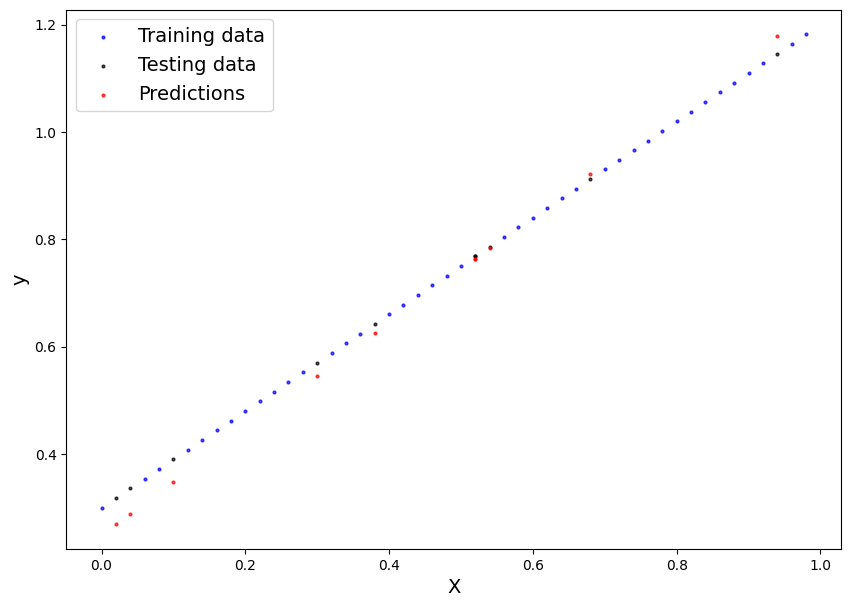

In [74]:
# Visualize result
plot_predictions(X_train, y_train, X_test, y_test, y_preds)

### 5/ Save Model

In [75]:
from pathlib import Path

# 1. Create models directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# 2. Create model save path
MODEL_NAME = "simple_model_pytorch.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# 3. Save the model state dict
print(f"Saving model to: {MODEL_SAVE_PATH}")
torch.save(obj=model.state_dict(), # only saving the state_dict() only saves the models learned parameters
           f=MODEL_SAVE_PATH)

Saving model to: models/simple_model_pytorch.pth


In [77]:
# Instantiate a fresh instance of LinearRegressionModelV2
loaded_model = LinearRegressionModel(X_train.shape[1], y_train.shape[1])

# Load model state dict
loaded_model.load_state_dict(torch.load(MODEL_SAVE_PATH))

# Put model to target device (if your data is on GPU, model will have to be on GPU to make predictions)
loaded_model.to(device)

print(f"Loaded model:\n{loaded_model}")
print(f"Model on device:\n{next(loaded_model.parameters()).device}")

Loaded model:
LinearRegressionModel()
Model on device:
cpu


<ipython-input-77-a450d1e09860>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(torch.load(MODEL_SAVE_PATH))


In [79]:
# Evaluate loaded model
loaded_model.eval()
with torch.inference_mode():
    loaded_model_preds = loaded_model(X_test)
y_preds == loaded_model_preds

tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True],
        [True]])